### DATASETS

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"clmenttr","key":"726509b304570c31915da43fb218c143"}'}

In [3]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                               title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
christianlillelund/donald-trumps-rallies                          Donald Trump's Rallies                               720KB  2020-09-26 10:25:08            474  
heeraldedhia/groceries-dataset                                    Groceries dataset                                    257KB  2020-09-17 04:36:08           2660  
andrewmvd/trip-advisor-hotel-reviews                              Trip Advisor Hotel Reviews                             5MB  2020-09-30 08:31:20           1554  
balraj98/stanford-background-dataset                              Stanford Background Dataset                           17MB 

In [4]:
!kaggle competitions download -c 'starcraft-2-player-prediction-challenge-2020'

 66% 9.00M/13.5M [00:00<00:00, 26.0MB/s]
100% 13.5M/13.5M [00:00<00:00, 34.2MB/s]
 93% 115M/124M [00:01<00:00, 70.2MB/s]
100% 124M/124M [00:01<00:00, 75.7MB/s]
  0% 0.00/625k [00:00<?, ?B/s]
100% 625k/625k [00:00<00:00, 88.0MB/s]
 90% 5.00M/5.57M [00:00<00:00, 38.9MB/s]
100% 5.57M/5.57M [00:00<00:00, 35.3MB/s]
  0% 0.00/20.8k [00:00<?, ?B/s]
100% 20.8k/20.8k [00:00<00:00, 21.9MB/s]


In [5]:
#Unzip data
! unzip TRAIN.CSV.zip 
! unzip TEST.CSV.zip 
! unzip TEST_LONG.CSV.zip 
! unzip TRAIN_LONG.CSV.zip 

Archive:  TRAIN.CSV.zip
  inflating: TRAIN.CSV               
Archive:  TEST.CSV.zip
  inflating: TEST.CSV                
Archive:  TEST_LONG.CSV.zip
  inflating: TEST_LONG.CSV           
Archive:  TRAIN_LONG.CSV.zip
  inflating: TRAIN_LONG.CSV          


##IMPORTS

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

### Loading the data

In [8]:
columns_names = ['battleneturl', 'played_race']
for i in range(2563):
  columns_names.append('s'+ str(i))

In [9]:
def read_train(filename):
  players = []
  data = []
  with open(filename, 'r') as f:
    for line in f:
      elements = line.rstrip("\n").split(",")
      id = elements[0]
      race = elements[1]
      accion = elements[2:]
      players.append(id)
      data.append([race, ", ".join([a.rstrip() for a in accion])])
  df = pd.DataFrame(data, columns=['race', 'actions'])
  players = pd.Series(players)
  return players, df

def read_test(filename):
  data = []
  with open(filename, 'r') as f:
    for line in f:
      elements = line.rstrip("\n").split(",")
      race = elements[0]
      accion = elements[1:]
      data.append([race, ", ".join([a.rstrip() for a in accion])])
  df = pd.DataFrame(data, columns=['race', 'actions'])
  return df

In [10]:
players, train_data = read_train('TRAIN.CSV')
test_data = read_test('TEST.CSV')

In [11]:
players.head()

0    http://eu.battle.net/sc2/en/profile/4234852/1/...
1    http://eu.battle.net/sc2/en/profile/3074362/1/...
2    http://eu.battle.net/sc2/en/profile/4234852/1/...
3    http://eu.battle.net/sc2/en/profile/3074362/1/...
4    http://eu.battle.net/sc2/en/profile/4234852/1/...
dtype: object

In [12]:
train_data.head()

,race,actions
0,Protoss,"Base, s, s, s, s, s, t5, Base, s, hotkey30, ho..."
1,Protoss,"s, Base, s, s, Base, s, s, Base, s, t5, hotkey..."
2,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5..."
3,Protoss,"Base, s, s, Base, s, s, s, t5, Base, s, hotkey..."
4,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5..."


In [13]:
test_data.head()

,race,actions
0,Zerg,"s, s, s, hotkey10, s, hotkey60, s, hotkey00, s..."
1,Terran,"s, hotkey30, hotkey00, t5, s, hotkey32, s, hot..."
2,Protoss,"Base, s, s, Base, s, hotkey20, hotkey30, hotke..."
3,Zerg,"s, s, s, s, hotkey20, s, hotkey40, t5, t10, ho..."
4,Protoss,"Base, s, s, Base, s, hotkey50, hotkey30, t5, h..."


In [14]:
train_data.actions[0]

'Base, s, s, s, s, s, t5, Base, s, hotkey30, hotkey00, t10, t15, t20, t25, t30, t35, s, hotkey32, s, hotkey32, s, hotkey32, s, t40, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, t45, hotkey32, SingleMineral, s, t50, s, hotkey32, s, hotkey32, t55, s, hotkey32, s, t60, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t65, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t70, s, hotkey32, s, hotkey32, s, s, hotkey32, s, hotkey32, s, hotkey32, t75, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t80, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t85, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t90, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, t95, s, hotkey10, hotkey32, s, hotkey10, t100, hotkey32, s, t105, hotkey32, t110, s, hotkey32, s, hotkey32, t115, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey32, s, hotkey4

##Statistics

Protoss    1210
Zerg       1061
Terran      781
Name: race, dtype: int64


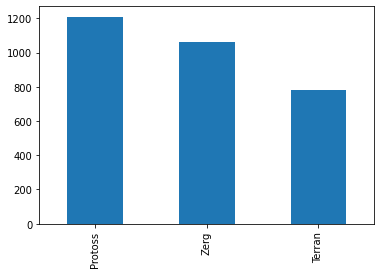

In [15]:
print(train_data.race.value_counts())
train_data.race.value_counts().plot.bar()

In [16]:
players.describe()

count                                                  3052
unique                                                  200
top       http://kr.battle.net/sc2/en/profile/2348639/1/...
freq                                                     58
dtype: object

##PREPROCESSING

In [31]:
#Getting the list of actions

def get_unique_actions(df):
  unique_actions = set()
  actions = df.actions
  for action in actions:
    for a in action.split(','):
      a = a.strip()
      if a != '' and a[0] != 't':
        unique_actions.add(a)
  return sorted(list(unique_actions))

In [32]:
# all the unique actions a player can do
unique_actions = get_unique_actions(train_data)
print(unique_actions)

['Base', 'SingleMineral', 'hotkey00', 'hotkey01', 'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20', 'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32', 'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51', 'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70', 'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82', 'hotkey90', 'hotkey91', 'hotkey92', 's']


In [33]:
# all the unique hotkey the player can press
unique_hotkeys = list(set([hotkey[:-1] for hotkey in unique_actions if 'hotkey' in hotkey]))
unique_hotkeys = sorted(unique_hotkeys)
print(unique_hotkeys)

['hotkey0', 'hotkey1', 'hotkey2', 'hotkey3', 'hotkey4', 'hotkey5', 'hotkey6', 'hotkey7', 'hotkey8', 'hotkey9']


In [34]:
# Defining the features 
# We're going to use the count of hotkeys, the count of unique keys, 
# the 10 first actions and the count of hotkeys use every 30s between 0 and 120s
first_actions_names = ['action_'+str(i) for i in range(1, 21)]
le = LabelEncoder()

def get_features(df):
  hotkeys = unique_actions
  keys = unique_hotkeys
  features = []
  for i, row in df.iterrows():
    first_actions = [] # Keeping track of the first x hotkeys
    race = row["race"]
    actions = row["actions"]     
    hotkeys_count = {hotkey:0 for hotkey in hotkeys}
    hotkeys_30s_count = {hotkey:0 for hotkey in hotkeys}
    hotkeys_60s_count = {hotkey:0 for hotkey in hotkeys}
    hotkeys_90s_count = {hotkey:0 for hotkey in hotkeys}
    hotkeys_120s_count = {hotkey:0 for hotkey in hotkeys}
    keys_count = {hotkey:0 for hotkey in keys}

    t_30s = False
    t_60s = False
    t_90s = False
    t_120s = False

    for action in actions.split(','):
      action = action.strip()
      if action in hotkeys:
        hotkeys_count[action]+=1
        #Putting actions realized every 30s in each count
        if not t_30s: 
          hotkeys_30s_count[action]+=1
        if not t_60s:
          hotkeys_60s_count[action]+=1
        if not t_90s:
          hotkeys_90s_count[action]+=1
        if not t_120s:
          hotkeys_60s_count[action]+=1

      if 'hotkey' in action:
        keys_count[action[:len(action)-1]] += 1
      if len(first_actions) < len(first_actions_names) and action in hotkeys:
        first_actions.append(action)

      if 't30' in action:
        t_30s = True
      if 't60' in action:
        t_60s = True
      if 't90' in action:
        t_90s = True
      if 't120' in action:
        t_120s = True
      
    while len(first_actions) < len(first_actions_names):
      first_actions.append('None')

    current = [race, *[hotkeys_count[hotkey] for hotkey in hotkeys], 
               *[hotkeys_30s_count[hotkey] for hotkey in hotkeys], 
               *[hotkeys_60s_count[hotkey] for hotkey in hotkeys],
               *[hotkeys_90s_count[hotkey] for hotkey in hotkeys],
               *[hotkeys_120s_count[hotkey] for hotkey in hotkeys],
               *[keys_count[key] for key in keys], *first_actions]
    features.append(current)

  new_df = pd.DataFrame(features, columns=['race', *hotkeys, 
                                           *[hotkey +'_30s' for hotkey in hotkeys], 
                                           *[hotkey +'_60s' for hotkey in hotkeys],
                                           *[hotkey +'_90s' for hotkey in hotkeys],
                                           *[hotkey +'_120s' for hotkey in hotkeys],
                                           *keys, *first_actions_names])
  
  new_df = pd.get_dummies(new_df, columns=['race'])
  
  for col in first_actions_names:
    new_df[col] = le.fit_transform(new_df[col])
  return new_df

In [35]:
# Show the data
features = get_features(train_data)
features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,hotkey22,hotkey30,hotkey31,hotkey32,hotkey40,hotkey41,hotkey42,hotkey50,hotkey51,hotkey52,hotkey60,hotkey61,hotkey62,hotkey70,hotkey71,hotkey72,hotkey80,hotkey81,hotkey82,hotkey90,hotkey91,hotkey92,s,Base_30s,SingleMineral_30s,hotkey00_30s,hotkey01_30s,hotkey02_30s,hotkey10_30s,hotkey11_30s,...,hotkey80_120s,hotkey81_120s,hotkey82_120s,hotkey90_120s,hotkey91_120s,hotkey92_120s,s_120s,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,action_10,action_11,action_12,action_13,action_14,action_15,action_16,action_17,action_18,action_19,action_20,race_Protoss,race_Terran,race_Zerg
0,66,5,5,0,41,63,0,350,37,0,185,1,0,401,5,0,255,4,0,114,3,0,18,1,0,0,0,0,0,4,0,0,674,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,46,413,222,402,260,118,21,1,0,4,0,9,16,21,24,25,0,29,10,3,26,11,28,11,28,11,28,11,26,11,1,0,0
1,12,0,2,0,83,65,3,448,15,0,215,7,0,342,3,0,308,0,0,0,0,0,0,0,0,0,1,0,16,1,0,18,538,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,85,516,230,349,311,0,0,0,17,19,3,0,16,21,0,25,27,0,27,10,26,11,28,11,28,11,28,11,26,11,1,0,0
2,47,3,3,0,18,17,0,130,9,0,126,1,0,320,7,0,130,3,0,88,1,0,11,0,0,0,0,0,0,2,0,2,430,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,21,147,135,321,137,91,12,0,0,4,0,9,16,21,0,25,11,3,27,11,26,11,28,11,28,11,28,27,11,25,1,0,0
3,21,0,2,0,39,32,1,259,14,0,70,6,0,245,3,0,284,0,0,0,0,0,0,0,0,0,0,0,0,1,0,14,397,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,41,292,84,251,287,0,0,0,0,15,0,9,16,0,24,25,27,0,27,10,26,11,28,11,28,11,28,11,26,11,1,0,0
4,2,0,1,0,0,10,0,52,6,0,38,1,0,200,2,0,84,1,0,14,0,0,0,0,0,0,0,0,0,0,0,0,208,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,62,44,201,86,15,0,0,0,0,0,9,16,21,0,25,11,3,27,11,26,11,28,11,28,11,28,11,26,11,1,0,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, players, test_size=0.3, random_state=42)

In [49]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 40),
              "max_features": randint(1, 36),
              "min_samples_leaf": randint(1, 20),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
#tree = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree.fit(X_train, y_train)

# Print the tuned parameters and score
#print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
#print("Best score is {}".format(tree_cv.best_score_))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
y_predict = tree.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(f1_score(y_test, y_predict, average='weighted'))

0.7314410480349345
0.7228034409601454


In [51]:
# Using XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print(xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [52]:
predictions = xgb.predict(X_test)
print(accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions, average='weighted'))

0.8548034934497817
0.8424451355703723


## Predictions on test data

In [39]:
# Showing the data
test_data.head()

,race,actions
0,Zerg,"s, s, s, hotkey10, s, hotkey60, s, hotkey00, s..."
1,Terran,"s, hotkey30, hotkey00, t5, s, hotkey32, s, hot..."
2,Protoss,"Base, s, s, Base, s, hotkey20, hotkey30, hotke..."
3,Zerg,"s, s, s, s, hotkey20, s, hotkey40, t5, t10, ho..."
4,Protoss,"Base, s, s, Base, s, hotkey50, hotkey30, t5, h..."


In [40]:
# Get the features
test_df = get_features(test_data)
test_df.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,hotkey22,hotkey30,hotkey31,hotkey32,hotkey40,hotkey41,hotkey42,hotkey50,hotkey51,hotkey52,hotkey60,hotkey61,hotkey62,hotkey70,hotkey71,hotkey72,hotkey80,hotkey81,hotkey82,hotkey90,hotkey91,hotkey92,s,Base_30s,SingleMineral_30s,hotkey00_30s,hotkey01_30s,hotkey02_30s,hotkey10_30s,hotkey11_30s,...,hotkey80_120s,hotkey81_120s,hotkey82_120s,hotkey90_120s,hotkey91_120s,hotkey92_120s,s_120s,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,action_10,action_11,action_12,action_13,action_14,action_15,action_16,action_17,action_18,action_19,action_20,race_Protoss,race_Terran,race_Zerg
0,19,3,14,0,847,7,31,352,10,0,67,3,0,2,0,0,0,0,0,0,3,1,981,4,0,43,0,0,0,6,0,29,848,0,0,2,0,47,1,0,...,0,0,0,0,0,0,0,861,390,77,5,0,0,985,47,0,35,2,8,12,3,19,14,22,2,23,23,4,25,5,18,5,25,5,17,4,14,0,0,1
1,0,0,2,0,33,14,0,336,31,0,150,1,0,467,3,0,402,1,0,157,0,0,0,0,0,0,0,0,0,1,0,47,572,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,35,350,181,468,405,158,0,0,0,48,2,5,1,16,8,20,11,22,11,25,10,25,11,26,11,25,10,23,10,19,0,1,0
2,20,0,1,0,0,10,0,479,53,0,628,60,0,251,2,0,217,0,0,0,1,0,1130,3,0,32,5,0,49,0,0,0,556,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,489,681,311,219,0,1131,35,54,0,0,8,12,0,19,6,10,14,12,21,18,25,18,26,16,25,15,23,7,14,1,0,0
3,17,2,0,0,0,68,89,525,13,6,129,4,2,30,3,1,528,2,0,3,1,0,3,0,0,0,0,0,0,0,0,0,1588,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,682,148,36,532,5,4,0,0,0,2,8,12,16,6,20,12,7,13,25,13,25,25,26,25,11,22,13,8,11,0,0,1
4,21,0,3,0,0,4,7,74,8,0,30,11,0,16,5,0,24,1,0,83,0,0,0,1,0,3,4,0,1,0,0,0,236,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,85,38,27,29,84,0,4,5,0,0,8,12,0,19,12,10,10,23,15,25,15,25,16,25,14,22,15,19,12,1,0,0


In [53]:
# Realize the predictions
tree_preds = tree.predict(test_df)
xgb_preds = xgb.predict(test_df)

In [59]:
# Submission file
my_submission = pd.DataFrame({'RowId': test_df.index + 1, 'prediction': xgb_preds})
my_submission.head()

,RowId,prediction
0,1,http://eu.battle.net/sc2/en/profile/3538115/1/...
1,2,http://eu.battle.net/sc2/en/profile/2896854/1/...
2,3,http://eu.battle.net/sc2/en/profile/3973341/1/...
3,4,http://eu.battle.net/sc2/en/profile/250458/1/V...
4,5,http://us.battle.net/sc2/en/profile/4352638/1/...


In [60]:
#Creating file
my_submission.to_csv('submission.csv', index=False)

In [58]:
my_submission.shape

(340, 2)